<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/modeling/SARIMAX/SARIMAX_countyLevelForRegions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SARIMAX Prediction for COVID Cases

https://github.com/Violet-Spiral/covid-xprize/blob/main/models/sarima_models.ipynb

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15,10)
from sklearn.metrics import mean_squared_error
#import sys
#from pathlib import Path
#import sys
#sys.path.append("../")
#from src.model_testing import *

import plotly.graph_objects as go

import pickle
from tqdm import tqdm

pd.set_option('display.max_rows', 10)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Util method

In [3]:
def mean_percent_error(y_test, y_hat):
    from math import e
    error = np.abs(y_test - y_hat)
    percent_error = error/(y_test + e)
    mean_percent_error = percent_error.sum() / len(y_test)
    return mean_percent_error

## Load Datasets

In [4]:
superset_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/AllStates_Superset_dataset_Mar26.csv',low_memory=False)
superset_data.head()

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
0,2020-03-01,Alabama,1001,0,Autauga County,0.0,7.194,49,15.0,13.0,0.0,0.0,3.0,0.0,35.853419,Alabama,35,22,2.81,41.6,1.0,32.9,0.26,2.55,0,55601,-1.2,0.11,19,58786,19.0,2.8,48.68,19,101,3.79,0.33,0.025,0.0,0.0,37,47.1,0.0,0.0,0.0,0,0,0.0,28,0.4,3.5,3.2,0.3,0.0,0.0,0.0
1,2020-03-02,Alabama,1001,0,Autauga County,0.0,14.587,100,15.0,4.0,0.0,0.0,5.0,-1.0,35.853419,Alabama,11,13,3.33,40.9,0.5,42.0,0.80,2.53,0,55601,-1.9,0.11,19,58786,19.0,2.8,48.68,19,101,3.79,0.33,0.025,0.0,0.0,38,47.1,0.0,0.0,0.0,0,0,0.0,28,0.4,3.5,3.2,0.3,0.0,0.0,0.0
2,2020-03-03,Alabama,1001,0,Autauga County,0.0,13.865,95,22.0,8.0,0.0,0.0,4.0,-1.0,35.853419,Alabama,10,13,3.30,40.6,0.4,37.4,0.77,2.53,0,55601,-1.9,0.11,19,58786,19.0,2.8,48.68,19,101,3.79,0.33,0.025,0.0,0.0,39,47.1,0.0,0.0,0.0,0,0,0.0,35,0.4,3.5,3.2,0.3,0.0,0.0,0.0
3,2020-03-04,Alabama,1001,0,Autauga County,0.0,13.880,95,5.0,-4.0,0.0,0.0,3.0,2.0,35.853419,Alabama,19,16,3.04,40.7,0.5,35.4,0.77,2.27,0,55601,-12.0,0.11,19,58786,19.0,2.8,48.68,19,101,3.79,0.33,0.025,0.0,0.0,40,47.1,0.0,0.0,0.0,0,0,0.0,35,0.4,3.5,3.2,0.3,0.0,0.0,0.0
4,2020-03-05,Alabama,1001,0,Autauga County,0.0,14.659,100,7.0,12.0,0.0,0.0,3.0,1.0,35.853419,Alabama,12,14,3.29,41.5,0.6,43.2,0.83,2.46,0,55601,-4.7,0.11,19,58786,19.0,2.8,48.68,19,101,3.79,0.33,0.025,0.0,0.0,41,47.1,0.0,0.0,0.0,0,0,0.0,35,0.4,3.5,3.2,0.3,0.0,0.0,0.0


In [5]:
superset_data['Date'] =  pd.to_datetime(superset_data['Date'], format='%Y-%m-%d')

In [6]:
superset_data = superset_data.set_index('Date')

In [7]:
superset_data.tail()

,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-24,Wyoming,56041,0,Uinta County,0.0,2.945,94,5.0,0.0,0.0,-10.0,-53.0,12.0,3.822405,Wyoming,30,22,3.44,26.0,17.6,39.0,0.61,2.83,0,20299,13.6,3.6,18,58235,0.1,9.1,50.97,5,147,3.76,0.5,0.017,0.4762,21.64,0,47.413044,8.9,827.97,17.25,24,240,57.17,77,1.0,6.5,27.1,1.3,1.13,0.000000,68.265150
2020-12-25,Wyoming,56041,0,Uinta County,0.0,1.042,33,-93.0,0.0,0.0,-16.0,-79.0,22.0,3.822405,Wyoming,50,33,2.31,29.9,20.1,53.1,0.61,1.70,0,20299,-31.8,3.6,18,58235,0.1,9.1,50.97,5,147,3.76,0.5,0.017,0.2463,20.25,1,47.503677,8.9,827.97,17.42,24,174,56.50,77,1.0,6.5,27.1,1.3,1.14,0.000000,53.486097
2020-12-26,Wyoming,56041,20,Uinta County,0.0,1.902,60,-10.0,0.0,0.0,-24.0,-16.0,0.0,3.822405,Wyoming,35,27,3.00,33.9,24.6,48.6,0.62,2.37,20,20299,-4.9,3.6,18,58235,0.1,9.1,50.97,5,147,3.76,0.5,0.017,0.3284,21.08,2,47.600503,9.0,827.97,17.60,24,279,56.50,77,1.0,6.5,27.1,1.3,1.14,98.527021,62.635035
2020-12-27,Wyoming,56041,2,Uinta County,0.0,1.774,56,0.0,0.0,0.0,-3.0,-16.0,0.0,3.822405,Wyoming,36,28,2.60,40.6,31.0,63.4,0.69,1.91,2,20299,-23.3,3.6,18,58235,0.1,9.1,50.97,5,147,3.76,0.5,0.017,0.3613,19.44,3,47.707402,9.0,827.97,17.80,25,294,56.50,77,1.0,6.5,27.1,1.3,1.14,9.852702,57.004919
2020-12-28,Wyoming,56041,10,Uinta County,0.0,2.423,77,0.0,0.0,0.0,4.0,-31.0,8.0,3.822405,Wyoming,33,25,3.12,30.1,18.3,41.9,0.85,2.27,10,20299,-8.9,3.6,18,58235,0.1,9.1,50.97,5,147,3.76,0.5,0.017,0.5255,19.99,4,47.820319,8.9,853.47,18.00,25,241,56.50,77,1.0,6.5,27.1,1.3,1.14,49.263511,42.929631


## SARIMAX County Level

## Variable declaration

In [ ]:
county_name = 'Washington County'
state_name = 'Oregon'
state_code = 'OR'
county_code = 'WC'
#DONE

In [ ]:
state_name = 'California'
county_name = 'Solano County'
state_code = 'CA'
county_code = 'SL'
#DONE

In [24]:
state_name='Iowa'
county_name = 'Polk County'
state_code = 'IA'
county_code = 'PL'
#DONE

In [64]:
state_name = 'Wisconsin'
county_name = 'Milwaukee County'
state_code = 'WI'
county_code = 'ML'
#DONE

In [95]:
state_name = 'Arkansas'
county_name = 'Pulaski County'
state_code = 'AR'
county_code = 'PU'
#DONE

In [131]:
state_name = 'Texas'
county_name = 'Collin County'
state_code = 'TX'
county_code = 'CL'
#DONE

In [157]:
state_name = 'New Jersey'
county_name = 'Bergen County'
state_code = 'NJ'
county_code = 'BR'
#DONE

In [187]:
state_name = 'New York'
county_name = 'Queens County'
state_code = 'NY'
county_code = 'QU'
#

## Loading data

In [188]:
state_county_superset_data = superset_data[(superset_data['County Name'] == county_name) & (superset_data['Province_State'] == state_name)]
print(state_county_superset_data.shape)
state_county_superset_data.head()

(292, 55)


,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,New York,36081,0,Queens County,0.0,1.339,35,3.0,1.0,14.0,-4.0,1.0,0.0,8158.437153,New York,46,37,3.26,38.4,4.7,32.0,0.43,2.83,0,2278906,-6.3,51.31,21,64987,17.2,28.0,48.49,3300,81,2.74,0.22,0.029,0.0,0.0,37,63.5,0.0,0.00,0.0,0,0,0.00,28,0.7,4.5,4.2,0.8,0.0,0.0,0.0
2020-03-02,New York,36081,0,Queens County,0.0,3.813,99,4.0,5.0,25.0,-4.0,6.0,0.0,8158.437153,New York,21,25,3.95,40.4,3.3,29.5,0.90,3.06,0,2278906,1.3,51.31,21,64987,17.2,28.0,48.49,3300,81,2.74,0.22,0.029,0.0,0.0,38,63.5,0.0,0.00,0.0,0,0,0.01,28,0.7,4.5,4.2,0.8,0.0,0.0,0.0
2020-03-03,New York,36081,0,Queens County,0.0,3.747,98,2.0,4.0,9.0,-3.0,4.0,0.0,8158.437153,New York,20,25,3.97,40.8,3.0,29.3,0.90,3.07,0,2278906,1.7,51.31,21,64987,17.2,28.0,48.49,3300,81,2.74,0.22,0.029,0.0,0.0,39,63.5,0.0,0.00,0.0,0,0,0.01,35,0.7,4.5,4.2,0.8,0.0,0.0,0.0
2020-03-04,New York,36081,0,Queens County,0.0,3.822,99,7.0,8.0,28.0,-4.0,2.0,0.0,8158.437153,New York,20,24,4.03,41.1,3.1,29.2,0.90,3.13,0,2278906,3.6,51.31,21,64987,17.2,28.0,48.49,3300,81,2.74,0.22,0.029,0.0,0.0,40,63.5,11.1,0.00,0.0,0,1,0.04,35,0.7,4.5,4.2,0.8,0.0,0.0,0.0
2020-03-05,New York,36081,0,Queens County,0.0,4.052,106,8.0,8.0,31.0,-2.0,3.0,0.0,8158.437153,New York,20,24,4.10,41.0,3.1,29.4,0.89,3.21,0,2278906,6.3,51.31,21,64987,17.2,28.0,48.49,3300,81,2.74,0.22,0.029,0.0,0.0,41,63.5,22.4,0.01,0.0,0,3,0.05,35,0.7,4.5,4.2,0.8,0.0,0.0,0.0


 **Note**:
 I have removed the other columns and verified with only date column

## filter columns

In [189]:
#columns = ['Tests.done.1000.people','X..staying.home','Unemployment.rate','X..people.older.than.60','X..working.from.home','X.days..decreasing.ILI.cases','X..Male','X..out.of.county.trips','parks_percent_change_from_baseline','Work.trips.person','m50_index','FIPS','Imported.COVID.cases','X..out.of.state.trips','Miles.person','X.days..decreasing.COVID.cases','grocery_and_pharmacy_percent_change_from_baseline','transit_stations_percent_change_from_baseline','Testing.capacity','retail_and_recreation_percent_change_from_baseline','Unemployment.claims.1000.people', 'New Cases/100k population']
columns = ['New Cases/100k population']
state_county_superset_data = state_county_superset_data[columns]
state_county_superset_data.head()

,New Cases/100k population
Date,
2020-03-01,0.0
2020-03-02,0.0
2020-03-03,0.0
2020-03-04,0.0
2020-03-05,0.0


In [190]:
state_county_superset_data.shape

(292, 1)

### Check Date Range

In [191]:
state_county_superset_data = state_county_superset_data.reindex(pd.date_range("2020-03-01", "2020-12-28"), fill_value=0.0)

### Plot 'New Cases/100k population'

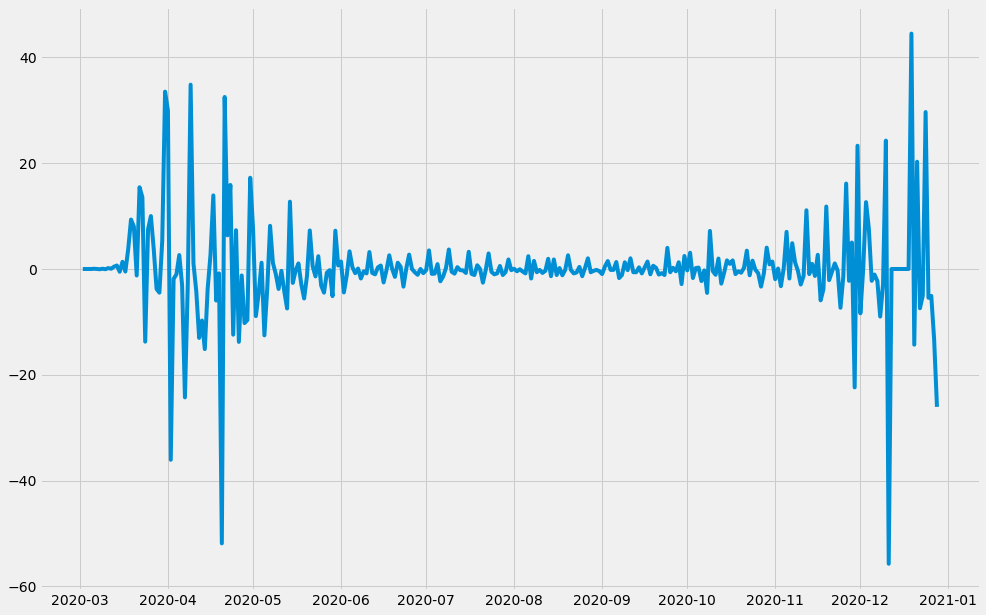

In [192]:
# differencing of one day turns total cases into daily new cases
# by tracking the change rather than the total
prediction = 'New Cases/100k population'
plt.plot(state_county_superset_data[prediction].diff(1)[:])

## Test and Training Split

In [193]:
prediction = 'New Cases/100k population'
region = 'United States'

#dfjanusa = dfjan[(dfjan['Jurisdiction'] == 'NAT_TOTAL') & (dfjan['CountryName'] == region)][:-1]

true_value = state_county_superset_data[prediction]
true_value.index.freq = 'D'
true_value = true_value.interpolate(method = 'time', limit_direction = 'forward', limit_area = 'inside').fillna(0.0)

train = true_value[true_value.index < '2020-12-01']
test = true_value[true_value.index >= '2020-12-01']
train

#train-test split-temp
state_county_superset_data = state_county_superset_data.fillna(method = 'ffill')
train_df = state_county_superset_data[state_county_superset_data.index < '2020-12-01']
test_df = state_county_superset_data[(state_county_superset_data.index >= '2020-12-01') & (state_county_superset_data.index < '2021-01-01')]

train = train_df[prediction]
test = test_df[prediction]
true = state_county_superset_data[prediction]
train.index.freq = 'D'
test.index.freq = 'D'
true.index.freq = 'D'

In [194]:
print("train:", train.shape)
print("test:", test.shape)

train: (275,)
test: (28,)


In [195]:
train.head(2)

2020-03-01    0.0
2020-03-02    0.0
Freq: D, Name: New Cases/100k population, dtype: float64

## Seasonal Decompose

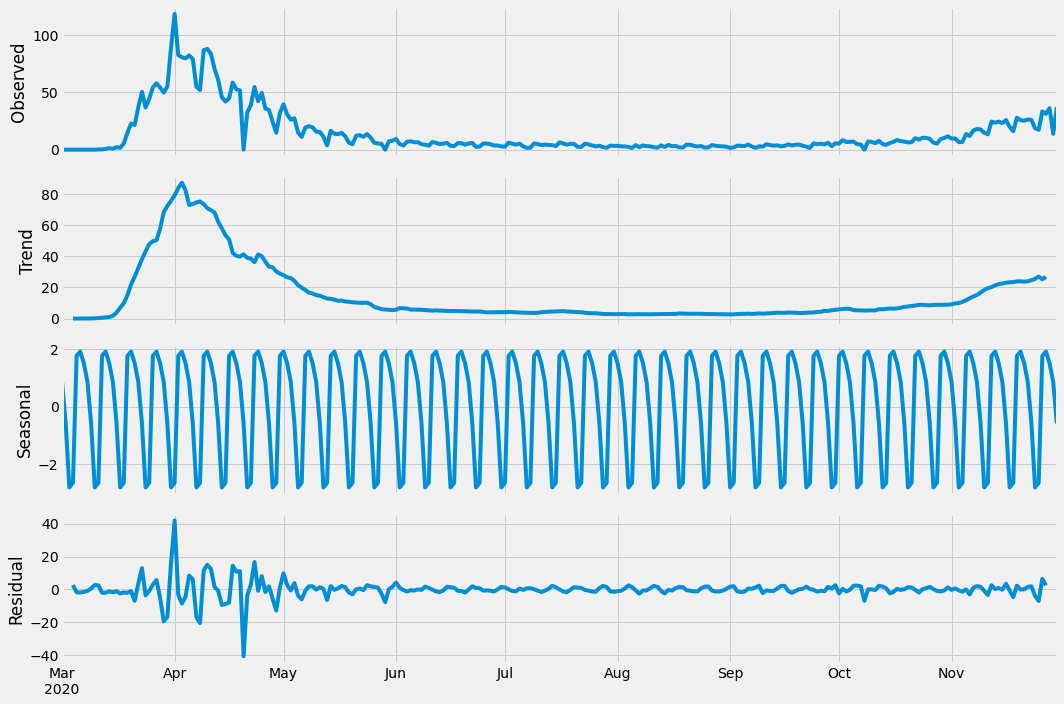

In [196]:
df = state_county_superset_data.fillna(method = 'ffill')
results = seasonal_decompose(train_df[prediction],two_sided = True, model='additive')
results.plot()
plt.show()

In [197]:
len(train.index.day_name())

275

In [198]:
len(train_df['New Cases/100k population'].values)

275

### Visualizing `cases`  Vs `day of the week`

Text(0.5, 0, 'Day of the Week')

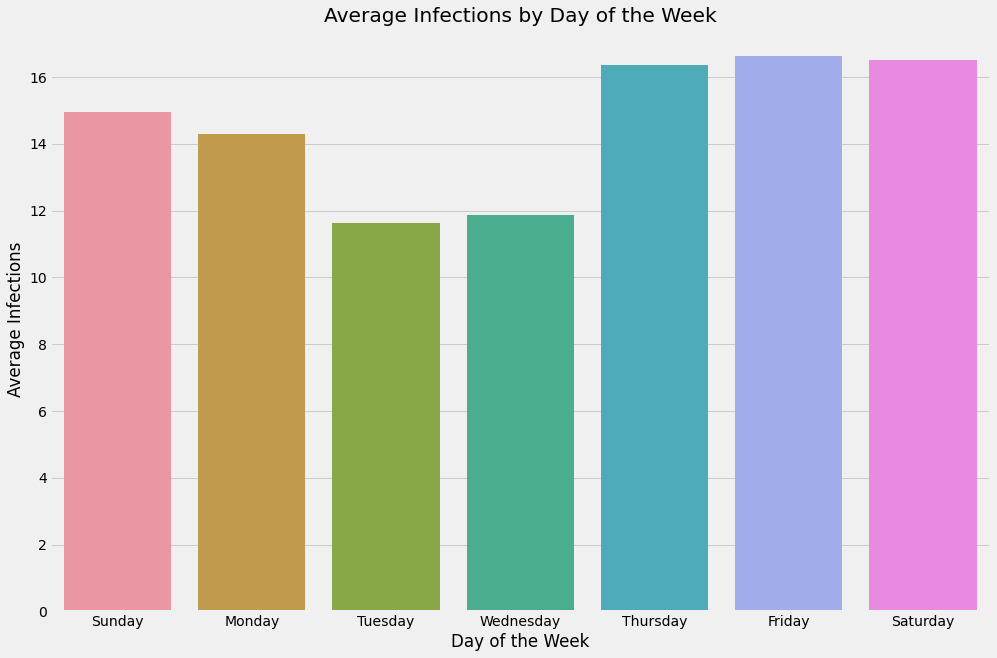

In [199]:
import seaborn as sns
ax = plt.subplot()
sns.barplot(x=train.index.day_name(), y=train_df[prediction].values, ax=ax, ci=False,
           order = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
#ax.set_ylim([3600000,4000000])
ax.set_title('Average Infections by Day of the Week')
ax.set_ylabel('Average Infections')
ax.set_xlabel('Day of the Week')

### Sarimax Model

### Determine hyperparameter

In [200]:
cbrt_train =  np.cbrt(train)
flag = True
test_results = pd.DataFrame(columns = ['MPE'])
for p in range(0,4):
    for d in range(1,3):
        for q in range(0,4):
            for P in range(0,4):
                for D in range(1,3):
                    for Q in range(0,4):
                        model = SARIMAX(cbrt_train, order =(p,d,q), seasonal_order = (P,D,Q,7),
                                       freq = 'D')
                        fit_model = model.fit(maxiter = 200, disp = False)
                        yhat = fit_model.forecast(len(test))
                        yhat = yhat**3
                        ind = f'order = ({p},{d},{q}), seasonal_order = ({P},{D},{Q},7)'
                        mpe = mean_percent_error(test,yhat)
                        print(f'trying {ind}, MPE = {mpe}')
                        test_results.loc[ind,'MPE'] = mpe
                        if mpe <=2.1:
                          break

test_results.min()

trying order = (0,1,0), seasonal_order = (0,1,0,7), MPE = 6.842720378106847
trying order = (0,1,0), seasonal_order = (0,1,1,7), MPE = 4.832109538225895
trying order = (0,1,0), seasonal_order = (0,1,2,7), MPE = 4.903322069233414
trying order = (0,1,0), seasonal_order = (0,1,3,7), MPE = 4.90126362765617
trying order = (0,1,0), seasonal_order = (0,2,0,7), MPE = 16.19954821092982


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



trying order = (0,1,0), seasonal_order = (0,2,1,7), MPE = 6.929024719931344
trying order = (0,1,0), seasonal_order = (0,2,2,7), MPE = 3.978560245946538
trying order = (0,1,0), seasonal_order = (0,2,3,7), MPE = 3.6381843983967657
trying order = (0,1,0), seasonal_order = (1,1,0,7), MPE = 5.510360624122531
trying order = (0,1,0), seasonal_order = (1,1,1,7), MPE = 4.901604419262332
trying order = (0,1,0), seasonal_order = (1,1,2,7), MPE = 4.862722424354705
trying order = (0,1,0), seasonal_order = (1,1,3,7), MPE = 4.862252900075382
trying order = (0,1,0), seasonal_order = (1,2,0,7), MPE = 6.628866094890079
trying order = (0,1,0), seasonal_order = (1,2,1,7), MPE = 5.453949653092219
trying order = (0,1,0), seasonal_order = (1,2,2,7), MPE = 3.6093868193930945
trying order = (0,1,0), seasonal_order = (1,2,3,7), MPE = 3.698976779081884
trying order = (0,1,0), seasonal_order = (2,1,0,7), MPE = 5.659817011158418
trying order = (0,1,0), seasonal_order = (2,1,1,7), MPE = 4.897832850859392
trying ord

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



trying order = (0,2,1), seasonal_order = (0,1,0,7), MPE = 7.043703469831464
trying order = (0,2,1), seasonal_order = (0,1,1,7), MPE = 4.320072434955067
trying order = (0,2,1), seasonal_order = (0,1,2,7), MPE = 4.415605604389613
trying order = (0,2,1), seasonal_order = (0,1,3,7), MPE = 4.410984230664978
trying order = (0,2,1), seasonal_order = (0,2,0,7), MPE = 15.372823986780606
trying order = (0,2,1), seasonal_order = (0,2,1,7), MPE = 7.328924614782834
trying order = (0,2,1), seasonal_order = (0,2,2,7), MPE = 9.677608727118956
trying order = (0,2,1), seasonal_order = (0,2,3,7), MPE = 9.829871787332591
trying order = (0,2,1), seasonal_order = (1,1,0,7), MPE = 5.497775181696999
trying order = (0,2,1), seasonal_order = (1,1,1,7), MPE = 4.415042771915923
trying order = (0,2,1), seasonal_order = (1,1,2,7), MPE = 4.323417761106089
trying order = (0,2,1), seasonal_order = (1,1,3,7), MPE = 4.324195240211465
trying order = (0,2,1), seasonal_order = (1,2,0,7), MPE = 5.611563161897453
trying orde

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



trying order = (0,2,3), seasonal_order = (2,1,0,7), MPE = 3.907013852749114
trying order = (0,2,3), seasonal_order = (2,1,1,7), MPE = 3.90836948768424
trying order = (0,2,3), seasonal_order = (2,1,2,7), MPE = 3.845113474500786
trying order = (0,2,3), seasonal_order = (2,1,3,7), MPE = 3.8477996555133385
trying order = (0,2,3), seasonal_order = (2,2,0,7), MPE = 2.4792411112219312
trying order = (0,2,3), seasonal_order = (2,2,1,7), MPE = 5.532785296148179
trying order = (0,2,3), seasonal_order = (2,2,2,7), MPE = 7.9591874537605785
trying order = (0,2,3), seasonal_order = (2,2,3,7), MPE = 4.557806380337343
trying order = (0,2,3), seasonal_order = (3,1,0,7), MPE = 4.435945098781601
trying order = (0,2,3), seasonal_order = (3,1,1,7), MPE = 3.8843866557804776
trying order = (0,2,3), seasonal_order = (3,1,2,7), MPE = 3.837729525801845
trying order = (0,2,3), seasonal_order = (3,1,3,7), MPE = 3.8278045849527693
trying order = (0,2,3), seasonal_order = (3,2,0,7), MPE = 3.3460969120593447
trying 

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



trying order = (1,1,0), seasonal_order = (0,2,1,7), MPE = 3.773063275691453
trying order = (1,1,0), seasonal_order = (0,2,2,7), MPE = 2.8680518272653264
trying order = (1,1,0), seasonal_order = (0,2,3,7), MPE = 2.78906434836878
trying order = (1,1,0), seasonal_order = (1,1,0,7), MPE = 3.6278724852377677
trying order = (1,1,0), seasonal_order = (1,1,1,7), MPE = 3.752313198121467
trying order = (1,1,0), seasonal_order = (1,1,2,7), MPE = 3.7377858607695194
trying order = (1,1,0), seasonal_order = (1,1,3,7), MPE = 3.738097176634664
trying order = (1,1,0), seasonal_order = (1,2,0,7), MPE = 3.0500503171997155
trying order = (1,1,0), seasonal_order = (1,2,1,7), MPE = 3.5297624095071995
trying order = (1,1,0), seasonal_order = (1,2,2,7), MPE = 2.7798409334257603
trying order = (1,1,0), seasonal_order = (1,2,3,7), MPE = 2.8840062741375214
trying order = (1,1,0), seasonal_order = (2,1,0,7), MPE = 3.954321518015163
trying order = (1,1,0), seasonal_order = (2,1,1,7), MPE = 3.7531975723241047
tryin

KeyboardInterrupt: ignored

In [201]:
test_results.min()

MPE    2.206551
dtype: float64

In [202]:
test_results.sort_values(by = 'MPE') [11:20]

,MPE
"order = (1,1,0), seasonal_order = (1,2,2,7)",2.77984
"order = (0,1,2), seasonal_order = (2,2,0,7)",2.78477
"order = (1,1,0), seasonal_order = (0,2,3,7)",2.78906
"order = (1,1,0), seasonal_order = (2,2,2,7)",2.85952
"order = (1,1,0), seasonal_order = (0,2,2,7)",2.86805
"order = (1,1,0), seasonal_order = (1,2,3,7)",2.88401
"order = (0,1,1), seasonal_order = (3,2,3,7)",2.89515
"order = (1,1,0), seasonal_order = (1,2,0,7)",3.05005
"order = (0,1,2), seasonal_order = (2,2,2,7)",3.132


mpe = 3.132000749514397


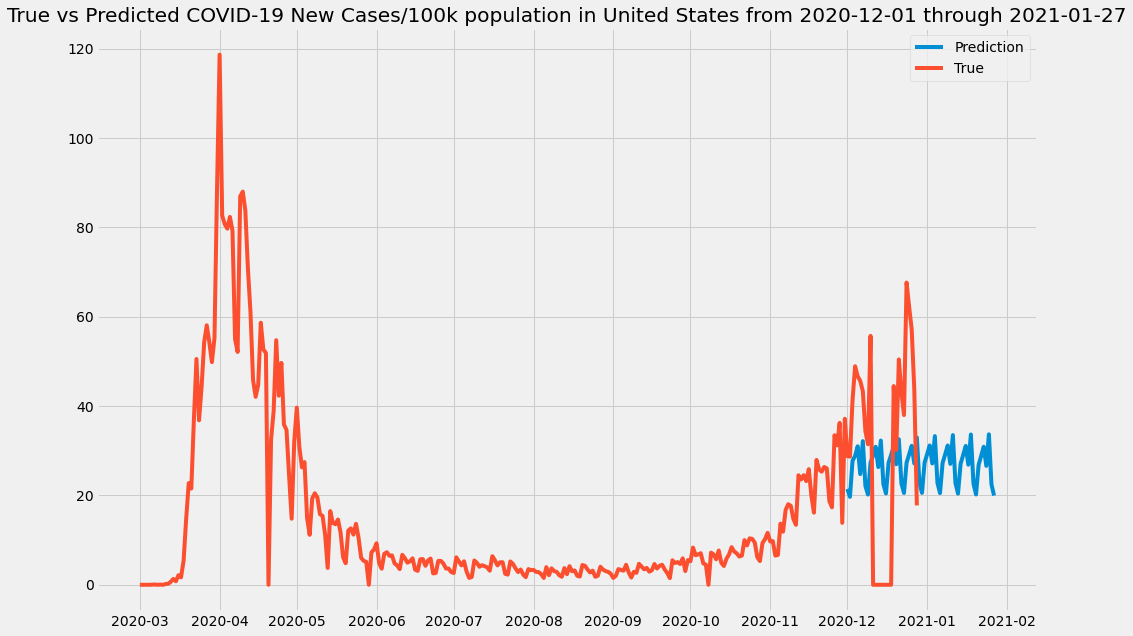

In [205]:
cbrt_train =  np.cbrt(train)

model2 = SARIMAX(cbrt_train, order = (0,1,2), seasonal_order = (2,2,2,7),
                                       freq = 'D')
fit_model2 = model2.fit(maxiter = 200, disp = False)
yhat = fit_model2.forecast(len(test)+30)**3
mpe = mean_percent_error(test,yhat)
print(f'mpe = {mpe}')

fig = go.Figure(layout_title_text = f'January Prediction from 2020 Data: Accuracy= {round((1-mpe)*100,2)}%',)
plt.plot(yhat, label='Prediction')
plt.plot(true, label='True')
plt.legend()
plt.title(f'True vs Predicted COVID-19 {prediction} in {region} from {yhat.index.date.min()} through {yhat.index.date.max()}') 
plt.savefig('SARIMA_prediction2021_01_05.png')
pickle.dump(fit_model2, open('SARIMAX_prediction_model.pickle', 'wb'))

In [206]:
yhat

2020-12-01    21.436698
2020-12-02    19.680558
2020-12-03    27.755948
2020-12-04    28.875769
2020-12-05    31.003964
                ...    
2021-01-23    30.910412
2021-01-24    26.631685
2021-01-25    33.686437
2021-01-26    22.481765
2021-01-27    19.973275
Freq: D, Length: 58, dtype: float64

In [207]:
test_df[['New Cases/100k population']].tail(10)

,New Cases/100k population
2020-12-19,44.495034
2020-12-20,30.189924
2020-12-21,50.462810
2020-12-22,43.046971
2020-12-23,38.000690
2020-12-24,67.664046
2020-12-25,62.222839
2020-12-26,57.132677
2020-12-27,43.836823
2020-12-28,17.771685


In [208]:
yhat.keys()
yhat

2020-12-01    21.436698
2020-12-02    19.680558
2020-12-03    27.755948
2020-12-04    28.875769
2020-12-05    31.003964
                ...    
2021-01-23    30.910412
2021-01-24    26.631685
2021-01-25    33.686437
2021-01-26    22.481765
2021-01-27    19.973275
Freq: D, Length: 58, dtype: float64

## Create dataframe from `yhat` value

In [209]:
lst = []

for y in train.keys():
  #print(y)
  row = {}
  row['Date'] = y
  row['Province_State'] = state_name
  row['County Name'] = county_name
  row['New Cases/100k population'] = train[y]
  lst.append(row)

In [210]:

for y in yhat.keys():
  #print(y)
  row = {}
  row['Date'] = y
  row['Province_State'] = state_name
  row['County Name'] = county_name
  row['New Cases/100k population'] = yhat[y]
  lst.append(row)

df_estimates = pd.DataFrame(lst) 

In [211]:
#dec-jan
df_estimates.head()

,Date,Province_State,County Name,New Cases/100k population
0,2020-03-01,New York,Queens County,0.0
1,2020-03-02,New York,Queens County,0.0
2,2020-03-03,New York,Queens County,0.0
3,2020-03-04,New York,Queens County,0.0
4,2020-03-05,New York,Queens County,0.0


In [212]:
df_estimates.tail()

,Date,Province_State,County Name,New Cases/100k population
328,2021-01-23,New York,Queens County,30.910412
329,2021-01-24,New York,Queens County,26.631685
330,2021-01-25,New York,Queens County,33.686437
331,2021-01-26,New York,Queens County,22.481765
332,2021-01-27,New York,Queens County,19.973275


## Export file to csv

In [213]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'
filename = state_code+'_'+county_code+'_SARIMAX_estimates'+datetime.now().strftime("%b%d")+'.csv' 

print(filename)
df_estimates.to_csv(location+filename,index=False)

NY_QU_SARIMAX_estimatesApr03.csv


# Result 


|NO|State | County | MPE|
|--- |--- | --- | ---|
1.|OR|Washington county | 4.728401442576541|
2.|CA|Solano county|2.348202453583898|
3.|IA|Polk County |2.35827|
4.|WI|Milwaukee County|3.3387177750692456|
5.|AR|Pulaski County|3.3210407278818366|
6.|TX|Collin County|3.3021706074014867|
7.|NJ|Bergen County|3.2695330172904375|
8.|NY|Queens County|3.132000749514397 |
